In [1]:
import keras
import tensorflow as tf

tf.enable_eager_execution() # Must be called at program startup?

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda

# Somehow if you use keras.layers it'll throw an error. I guess if you are using eager execution, use tensorflow
# everywhere. Side: Stuff this.

import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
n_x = 1 # Number of features
m = 1000 # Number of datapoints
l_1 = 20 # Number of neurons in first layer
n_z = 10 # Number of latent variables
alpha = 1e-1 # learning_rate
epochs = 10

batch_size = 128

In [3]:
def sampling(args):
    z_mean, z_logsigma = args
    epsilon = tf.random_normal(shape = tf.shape(z_mean))
    sampled_vector = tf.add(z_mean, tf.multiply(tf.exp(.5 * z_logsigma), epsilon))
    return sampled_vector

def total_vae_loss (x, x_pred, mu, logsigma, kl_weight =5e-3):
    kl_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1 - logsigma, axis = 1)
    reconstruction_loss = tf.reduce_mean((x - x_pred)**2)
    total_vae_loss = kl_weight * kl_loss + reconstruction_loss
    
    losses = {'kl_loss': kl_loss,
              'rc_loss': reconstruction_loss,
              'total_vae_loss': total_vae_loss}
    return losses

In [4]:
inputs = Input(shape = n_x, batch_size = batch_size) # Have to put batch size first, eh.

a_1 = Dense(units = l_1, activation = 'relu')(inputs)
z_mean = Dense(units = n_z)(a_1)
z_logsigma = Dense(units = n_z)(a_1)

# Implement the sampling layer
sampled_vector = Lambda(sampling)([z_mean, z_logsigma])

z_2 = Dense(units = n_x)(sampled_vector)

model = Model(inputs = inputs, outputs = [z_2, z_mean, z_logsigma])

print(model.summary())

# model.compile(optimizer = tf.train.AdamOptimizer(learning_rate = alpha),
#               loss = total_vae_loss) # No idea how to make loss work yet

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(128, 1)]           0                                            
__________________________________________________________________________________________________
dense (Dense)                   (128, 20)            40          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (128, 10)            210         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (128, 10)            210         dense[0][0]                      
______________________________________________________________________________________________

In [5]:
np.random.seed(0)
train_inputs = np.random.randn(m, n_x)
train_inputs = tf.convert_to_tensor(train_inputs, dtype = np.float32)
optimizer = tf.train.AdamOptimizer(learning_rate = alpha)
total_loss_values = []
rc_loss_values = []
kl_loss_values = []

batches_per_epoch = (m // batch_size) + 1 - (1 * (isinstance(m / batch_size, int)))

for i in range(epochs):
    for j in range(batches_per_epoch):
        if j == (batches_per_epoch - 1): # Last batch
            batch = train_inputs[j* batch_size:, :]
        else:
            batch = train_inputs[j * batch_size: (j+1) * batch_size, :] # All features, current batch
            
        with tf.GradientTape() as tape:
            z_2, z_mean, z_logsigma = model(batch)
            losses = total_vae_loss(batch, z_2, z_mean, z_logsigma)
            grads = tape.gradient(losses['total_vae_loss'], model.weights) # model.weights means variables here.
            optimizer.apply_gradients(zip(grads, model.weights), global_step = tf.train.get_or_create_global_step())

            # Track the losses
            total_loss_values.append(losses['total_vae_loss'].numpy().mean()) # loss_value is a tensor with loss for every single data point.
            rc_loss_values.append(losses['rc_loss'].numpy().mean())
            kl_loss_values.append(losses['kl_loss'].numpy().mean())

W0913 14:37:25.173268 140736468808640 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
grads

ListWrapper([<tf.Tensor: id=15712, shape=(1, 20), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.8303785 , -0.02845125,  0.        ,
         0.        ,  0.47825393,  0.        ,  0.        ,  0.        ,
         0.96911687,  0.779665  , -0.23814423,  0.        ,  1.4453807 ,
         0.        ,  1.1004559 ,  0.8062946 ,  0.6739404 ,  0.        ]],
      dtype=float32)>, <tf.Tensor: id=15711, shape=(20,), dtype=float32, numpy=
array([ 0.        ,  0.        ,  0.37363803, -0.0116832 ,  0.        ,
        0.        , -0.3522915 ,  0.        ,  0.        ,  0.        ,
        0.7819716 ,  0.5845484 , -1.2358255 ,  0.        , -0.43215165,
        0.        ,  0.9181182 ,  0.61657465, -0.5073752 ,  0.        ],
      dtype=float32)>, <tf.Tensor: id=15694, shape=(20, 10), dtype=float32, numpy=
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
     

In [7]:
model.get_weights()

[array([[-0.15818739, -0.22541077,  0.36805275,  0.39224416,  0.04973452,
          0.23607294, -0.5008655 ,  0.15109918, -0.33459502, -0.30358997,
          0.2992984 ,  0.3681052 , -0.4289083 , -0.14161275,  0.67537695,
         -0.2229477 ,  0.43871003,  0.14661917, -0.5059879 ,  0.00742209]],
       dtype=float32),
 array([-0.55987513, -1.0723885 , -0.08826826, -0.8018961 , -0.8291702 ,
        -0.73317367,  0.13021918, -0.83585495, -0.9236361 , -0.92507553,
        -0.21884786, -0.30865154,  0.4140635 , -0.8333012 ,  0.18592066,
        -1.0365622 , -0.25345287, -0.08655605, -0.14384086, -0.32135528],
       dtype=float32),
 array([[ 0.22616488, -0.4588003 , -0.5610014 , -0.1553893 ,  0.49584904,
          0.21288082, -0.29033768,  0.3614071 , -0.0332348 ,  0.04440038],
        [ 0.70294064,  0.02249481, -0.7033361 , -0.27879497, -0.08336231,
          0.43538517, -0.5238726 ,  0.45235658, -0.63570344,  0.20555255],
        [ 0.3463381 , -0.81130844, -0.30092353,  0.13005424,  0.0

In [8]:
losses

{'kl_loss': <tf.Tensor: id=15589, shape=(104,), dtype=float32, numpy=
 array([ 7.596257 , 14.825311 , 31.634369 ,  4.3008757, 13.84565  ,
         6.1944475,  2.9999301,  2.7415307,  7.5548797, 17.76817  ,
         5.041517 , 10.726187 ,  6.597619 , 10.759995 ,  7.264846 ,
        13.128723 ,  7.31218  , 21.862034 , 11.170436 ,  6.665256 ,
         3.023283 ,  3.5704765,  2.9639144,  3.2436042, 11.957181 ,
        10.103339 , 10.709149 ,  2.7370071,  2.8606772, 26.670296 ,
         3.6130455,  3.5561376,  2.9923453, 12.61615  , 14.306492 ,
         3.5528526,  2.8620055, 12.858019 ,  3.7782586,  7.457224 ,
         8.953291 , 15.603174 ,  7.055631 ,  5.10847  ,  2.9957252,
        10.370577 ,  3.315474 , 35.0604   ,  3.0620584,  2.7605715,
         2.7936392, 12.130091 ,  3.397487 ,  3.1537206,  8.401944 ,
         2.74525  , 11.686255 ,  4.3387885,  3.4682968,  2.7468464,
         5.6231933,  7.1586504, 26.801731 , 11.741108 ,  4.0762467,
         6.368722 ,  2.837137 ,  5.3083906,  4

Text(0.5,1,'TF_implementation_total_loss, alpha = 0.1')

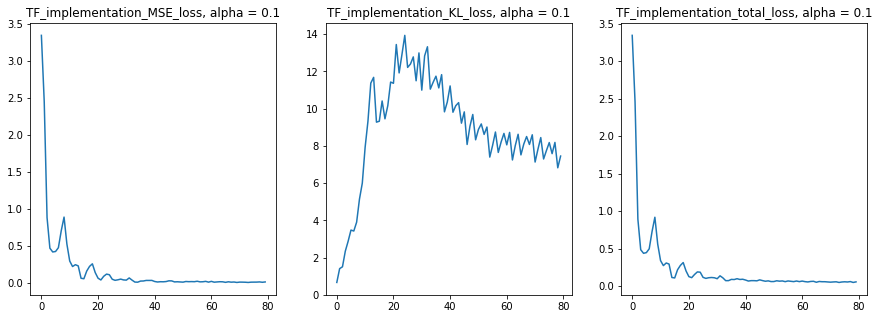

In [9]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.plot(rc_loss_values)
plt.title('TF_implementation_MSE_loss, alpha = {}'.format(alpha))

plt.subplot(132)
plt.plot(kl_loss_values)
plt.title('TF_implementation_KL_loss, alpha = {}'.format(alpha))

plt.subplot(133)
plt.plot(total_loss_values)
plt.title('TF_implementation_total_loss, alpha = {}'.format(alpha))

In [10]:
np.random.seed(0)
test_inputs = tf.convert_to_tensor(np.random.randn(n_x, 100).T, dtype = np.float32) # 100 samples which are 'normal'
test_inputs_anomaly = tf.convert_to_tensor(np.random.randn(n_x, 100).T, dtype = np.float32) # 100 samples which are anomalous
test_inputs_anomaly = 0.5 + test_inputs_anomaly # Actually have mean 1 and var 1.

# Send both of them through the model

def send_through_the_network(inputs, kl_weight = 0):
    z_2, mu, logsigma = model(inputs)
    kl_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1 - logsigma, axis = 1)
    reconstruction_loss = tf.reduce_mean((inputs - z_2)**2)
    total_vae_loss = kl_weight * kl_loss + reconstruction_loss
    return total_vae_loss

# Technically returning both KL-loss and rc loss, but KL loss is so low that it is as good as rc-loss.
print('This is the average loss from 100 points of "normal" data points: ' + str(tf.reduce_mean(send_through_the_network(test_inputs))))
print('This is the average loss from 100 points of "anomalous" data points: ' + str(tf.reduce_mean(send_through_the_network(test_inputs_anomaly))))

This is the average loss from 100 points of "normal" data points: tf.Tensor(0.01583208, shape=(), dtype=float32)
This is the average loss from 100 points of "anomalous" data points: tf.Tensor(0.016489869, shape=(), dtype=float32)
